In [1]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
from skimage import color
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
%matplotlib inline

Using TensorFlow backend.


# Load Datasets

Loads the SVHN and MNIST datasets. We'll be building a binary classifier that classifies an image as part of the MNIST dataset or SVHN dataset. 

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
mnist_train_X = mnist.train.images
mnist_test_X = mnist.test.images
mnist_train_y = mnist.train.labels
mnist_test_y = mnist.test.labels

In [4]:
svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')

In [5]:
svhn_train_X = svhn_train['X']
svhn_train_y = svhn_train['y']
svhn_test_X = svhn_test['X']
svhn_test_y = svhn_test['y']

# Preprocessing

SVHN images are in color and also larger than MNIST. For our classifier, we will grayscale the images and also resize them to be the same shape as MNIST.

In [6]:
gray_svhn_train = np.array([color.rgb2gray(svhn_train_X[:, :, :, i]) for i in range(svhn_train_X.shape[3])])
gray_svhn_test = np.array([color.rgb2gray(svhn_test_X[:, :, :, i]) for i in range(svhn_test_X.shape[3])])

We resize the images to 28 x 28

In [7]:
resized_gray_svhn_train = np.array([sk.img_as_float(scipy.misc.imresize(gray_svhn_train[i], (28, 28))) for i in range(gray_svhn_train.shape[0])])
resized_gray_svhn_test = np.array([sk.img_as_float(scipy.misc.imresize(gray_svhn_test[i], (28, 28))) for i in range(gray_svhn_test.shape[0])])

We now vectorize the SVHN dataset. 

In [8]:
svhn_train_X = resized_gray_svhn_train.reshape((resized_gray_svhn_train.shape[0], mnist_train_X.shape[1]))
svhn_test_X = resized_gray_svhn_test.reshape((resized_gray_svhn_test.shape[0], mnist_test_X.shape[1]))

We define the label for MNIST as 0 and the label for SVHN as 1.

In [9]:
mnist_train_labels = np.zeros(mnist_train_X.shape[0])
mnist_test_labels = np.zeros(mnist_test_X.shape[0])
svhn_train_labels = np.ones(svhn_train_X.shape[0])
svhn_test_labels = np.ones(svhn_test_X.shape[0])

We now prepare our data to be passed into our model. 

In [53]:
train_data = np.vstack((mnist_train_X, svhn_train_X))
train_labels = np.hstack((mnist_train_y, svhn_train_y))
test_data = np.vstack((mnist_test_X, svhn_test_X))
test_labels = np.hstack((mnist_test_y, svhn_test_y))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [12]:
train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
test_data, test_labels = skl.utils.shuffle(test_data, test_labels)

NameError: name 'train_labels' is not defined

# Model

In [ ]:
model = Sequential([
        Dense(units=64, input_dim=train_data.shape[1], activation='relu'),
        Dense(units=1, activation='sigmoid'),
    ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training

In [ ]:
model.fit(train_data, train_labels, epochs=2, batch_size=32)

# Testing

In [ ]:
loss_and_metrics = model.evaluate(test_data, test_labels, batch_size=20)

In [ ]:
loss_and_metrics

In [ ]:
def view_sample(img_vector):
    plt.figure()
    plt.imshow(img_vector.reshape((28, 28)), cmap='gray')
    
def get_sample_prediction(vectors, plot=True):
    if plot:
        [view_sample(vectors[i]) for i in range(vectors.shape[0])]
    return np.round(model.predict(vectors))
    
get_sample_prediction(test_data[9:16])

In [ ]:
model.predict(test_data[0:3])

# Simple GAN

In [ ]:
def initialize_generator():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model
#     return Sequential([
#         Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
#         Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
#         Dense(units=mnist_train.shape[1], activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
#     ])

def initialize_discriminator():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model
#     return Sequential([
#         Dense(units=500, input_dim=mnist_train.shape[1], activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
#         Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
#         Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
#     ])

def generator_with_discriminator(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

Let 0 define real, let 1 define fake (generated)

In [ ]:
def train(g, d, real_data, epochs=1):
    g_d = generator_with_discriminator(g, d)
    g_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for i in range(2):
        g_inputs = np.random.normal(size=(real_data.shape[0], 100))
        g_train_data = g.predict(g_inputs)
        real_labels, fake_labels = np.zeros(real_data.shape[0]), np.ones(real_data.shape[0])
        train_data, train_labels = np.vstack((real_data, g_train_data)), np.hstack((real_labels, fake_labels))
        train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
        d.trainable = True
        d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        d.fit(train_data, train_labels, batch_size=32, epochs=2)
        d.trainable = False
        g_d.fit(g_inputs, real_labels, batch_size=128, epochs=3)
    return g, d

In [ ]:
g, d = initialize_generator(), initialize_discriminator()
g, d = train(g, d, mnist_train[:1000].reshape((1000, 28, 28, 1)))

In [ ]:
g_images = g.predict(np.random.normal(size=(100, 100)))
print(d.predict_classes(g_images))
for i in range(10): 
    plt.figure()
    plt.imshow(g_images[:, :, :, 0][i], cmap='gray')

# MNIST & SVHN Classifier: f
We define a classifier for both MNIST and SVHN for our cross domain mapping.

In [10]:
def f_model(pretrain=True):
    f = Sequential([
        Conv2D(64, (3, 3), input_shape=(28, 28, 1), padding='same'), 
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3)), 
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3)), 
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
    ])
    if pretrain:
        f.add(Conv2D(10, (1, 1)))
        f.add(Activation('softmax'))
        f.add(Flatten())
    return f

### Initialize f

In [11]:
f = f_model()
f.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [12]:
encoder = OneHotEncoder()
svhn_train_y = encoder.fit_transform(svhn_train_y).todense()
svhn_test_y = encoder.fit_transform(svhn_test_y).todense()

In [13]:
svhn_train_y.shape

(73257, 10)

In [14]:
X_train = np.vstack((mnist_train_X, svhn_train_X))
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = np.vstack((mnist_test_X, svhn_test_X))
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = np.vstack((mnist_train_y, svhn_train_y))
y_test = np.vstack((mnist_test_y, svhn_test_y))
X_train, y_train = skl.utils.shuffle(X_train, y_train)
X_test, y_test = skl.utils.shuffle(X_test, y_test)

In [ ]:
f.fit(X_train, y_train, epochs=2)

In [15]:
f.load_weights('my_model_weights.h5')

### Validation

In [16]:
print(f.evaluate(X_test, y_test))

36000/36032 [============================>.] - ETA: 0s[0.23255370937239836, 0.93394760213143868]


# Generator: g


In [17]:
def g_model():
    return Sequential([
        Conv2DTranspose(512, (8, 8), input_shape=(1, 1, 128)),
        Activation('relu'),
        BatchNormalization(),
        Conv2DTranspose(256, (8, 8)),
        Activation('relu'),
        BatchNormalization(),
        Conv2DTranspose(128, (8, 8)),
        Activation('relu'),
        BatchNormalization(),
        Conv2DTranspose(1, (7, 7)),
        Activation('tanh'),
    ])

def extract_f(f_classifier):
    f = Sequential()
    for i in range(13):
        f.add(f_classifier.get_layer(index=i))
    return f

def discriminator():
    return Sequential([
        Conv2D(128, (3, 3), padding='same', input_shape=(28, 28, 1)),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same'),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same'),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(1, (4, 4), padding='valid'),
        Activation('relu'),
        Flatten(),
        Dense(1),
        Activation('sigmoid'),
    ])
    
def generator(f, g):
    model = Sequential()
    model.add(f)
    model.add(g)
    return model

In [18]:
g = g_model()
f.trainable = False
f_baseline = extract_f(f)
G = generator(f_baseline, g)
D = discriminator()

In [ ]:
G.load_weights('G.h5')
D.load_weights('D.h5')

# Training G and D

In [19]:
svhn_train_X = svhn_train_X.reshape(svhn_train_X.shape[0], 28, 28, 1)
svhn_test_X = svhn_test_X.reshape(svhn_test_X.shape[0], 28, 28, 1)
mnist_train_X = mnist_train_X.reshape(mnist_train_X.shape[0], 28, 28, 1)
mnist_test_X = mnist_test_X.reshape(mnist_test_X.shape[0], 28, 28, 1)

In [26]:
def train(g, d, mnist_X, svhn_X, epochs=1):
    g_d = generator_with_discriminator(g, d)
    g_d.compile(loss=loss_function(svhn_X, g), optimizer='adam', metrics=['accuracy'])
    
    for i in range(2000):
        # Generate MNIST examples for SVHN for training
        g_train_data = g.predict(svhn_X)
        
        # Label as real or fake 
        real_labels, fake_labels = np.zeros(mnist_X.shape[0]), np.ones(svhn_X.shape[0])
        train_data, train_labels = np.vstack((mnist_X, g_train_data)), np.hstack((real_labels, fake_labels))
        train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
        
        # Train discriminator on this real/fake data
        print('Training Discriminator')
        d.trainable = True
        d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        d.fit(train_data, train_labels, batch_size=32, epochs=2)
        
        # Train generator based on the outputs of the discriminator
        print('Training Generator')
        d.trainable = False
        g_d.fit(svhn_X, np.zeros(svhn_X.shape[0]), batch_size=128, epochs=2)
    g.save_weights('G.h5')
    d.save_weights('D.h5')
    return g, d

def loss_function(svhn_X, g):
    class_true = f.predict(svhn_X) 
    def loss(y_true, y_pred):
        class_pred = f.predict(g.predict(svhn_X))
        loss_gan = tf.reduce_mean(keras.losses.mean_squared_error(y_true, y_pred))
        loss_const = tf.reduce_mean(keras.losses.mean_squared_error(class_true, class_pred))
        return loss_gan + loss_const
    return loss

def generator_with_discriminator(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

In [ ]:
G, D = train(G, D, mnist_test_X[:10000], svhn_test_X[:10000])

Training Discriminator
Epoch 1/2
 2656/20000 [==>...........................] - ETA: 1703s - loss: 7.7435 - acc: 0.5196

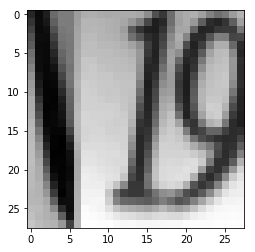

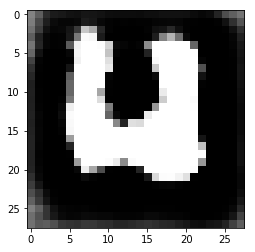

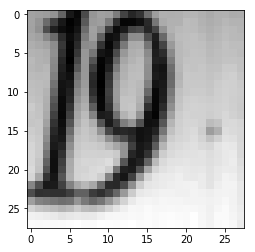

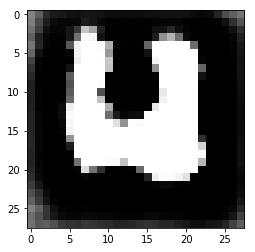

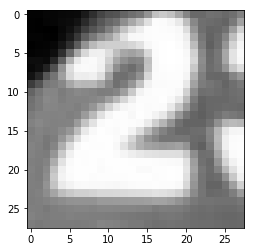

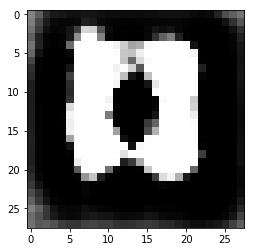

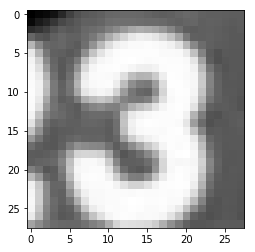

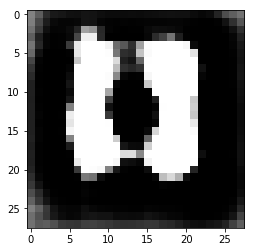

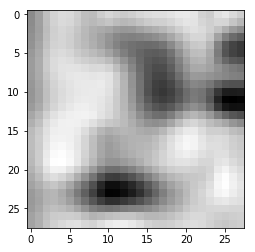

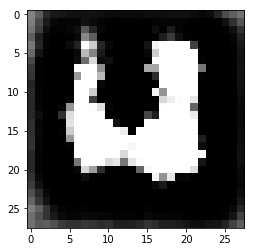

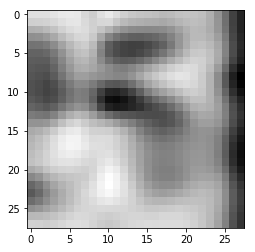

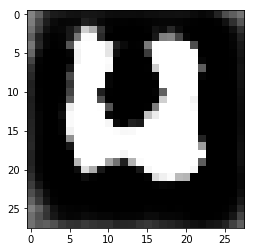

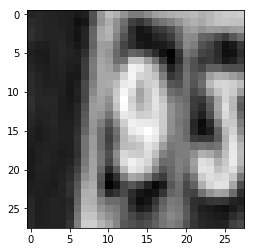

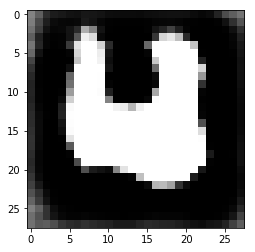

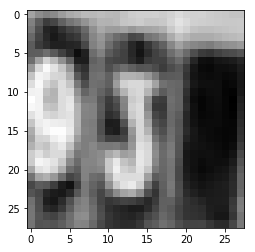

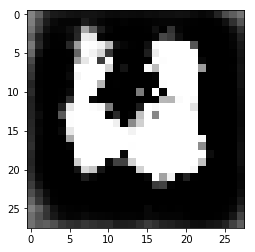

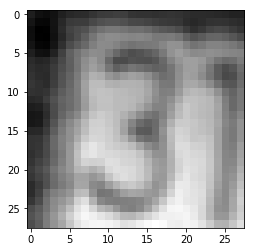

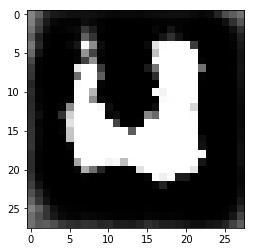

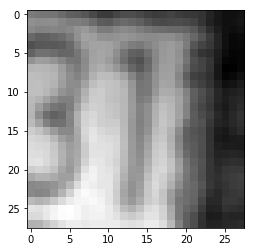

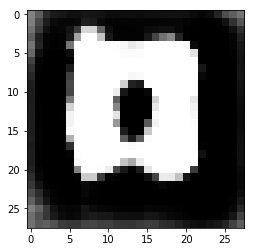

In [25]:

g_images = G.predict(svhn_train_X[10:40])
for i in range(10):
    plt.figure()
    plt.imshow(svhn_train_X[:, :, :, 0][i], cmap='gray')
    plt.figure()
    plt.imshow(g_images[:, :, :, 0][i], cmap='gray')


In [30]:
GD = generator_with_discriminator(G, D)

In [31]:
GD.predict(G.predict(svhn_train_X[10:40]))

array([[ 0.51052451],
       [ 0.51070338],
       [ 0.5038569 ],
       [ 0.50766897],
       [ 0.50988203],
       [ 0.51058739],
       [ 0.51056337],
       [ 0.51099759],
       [ 0.50919443],
       [ 0.50805187],
       [ 0.51075226],
       [ 0.5099979 ],
       [ 0.5098986 ],
       [ 0.51107967],
       [ 0.50957578],
       [ 0.50695229],
       [ 0.510203  ],
       [ 0.50591809],
       [ 0.51124954],
       [ 0.50983888],
       [ 0.51061553],
       [ 0.5107159 ],
       [ 0.50980228],
       [ 0.51018643],
       [ 0.50780386],
       [ 0.50802594],
       [ 0.51203376],
       [ 0.51005411],
       [ 0.4992097 ],
       [ 0.50676924]], dtype=float32)

(10000, 28, 28, 1)